In [2]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import random
from collections import deque
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten, Activation
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
import time
import statistics
from sklearn import preprocessing
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os.path

In [3]:
ticker = "FAS"

In [4]:
def getDB(ticker):
    tick = ticker
    # Load data
    data = yf.Ticker(tick)
    df = data.history(period="5y", interval="1d")
#     df = data.history(start="2018-12-01", end="2020-03-01")
#     start="2017-01-01", end="2017-04-30"
    
    # add data points
    df['close_per1'] = df.ta.percent_return(1)*100
    df['sma10'] = df.ta.sma(length=10)
    df['williams'] = df.ta.willr()


    df = df[[
            'open','close','sma10','williams','close_per1'
            ]]

    df = df.dropna()
    
    return df

In [5]:
data = getDB(ticker)
print(data['close_per1'].std())
print(data.head(5))
print(data.tail(5))

4.273944058579055
                 open      close      sma10   williams  close_per1
date                                                              
2017-01-23  39.383107  39.344631  40.028590 -75.882266   -0.486589
2017-01-24  39.613969  40.354687  40.004540 -45.000375    2.567200
2017-01-25  41.345535  41.653366  40.106509  -5.293969    3.218162
2017-01-26  41.768798  41.778419  40.187315  -7.967047    0.300224
2017-01-27  41.730314  41.124271  40.254653 -26.648555   -1.565756
                  open       close       sma10   williams  close_per1
date                                                                 
2021-12-23  128.460007  128.789993  126.142220 -28.456477    1.898880
2021-12-27  129.820007  132.520004  126.454931 -12.336443    2.896196
2021-12-28  132.479996  132.509995  127.225233 -13.113711   -0.007553
2021-12-29  133.600006  132.289993  127.731278 -14.056528   -0.166026
2021-12-30  133.139999  131.279999  128.028655 -18.384868   -0.763470


In [6]:
def set_data(ticker):
    df = getDB(ticker)

    df['CP_ol'] = 0
    df['CO_il'] = 0
    df['SMA10_il'] = 0
    df['W_il'] = 0
    
    value = df['close_per1'].std()
    
    # setting the outputs in the df
    for i in range(len(df)):
        if df.iloc[i]['close_per1'] > value:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 2
        elif df.iloc[i]['close_per1'] < -value:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 1
        else:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 0
    
    # setting the inputs in the df
    for i in range(len(df)-1):
        try:
            if df.iloc[i]['close'] < df.iloc[i+1]['open']:
                df.iloc[i+1, df.columns.get_loc('CO_il')] = 1
            else:
                df.iloc[i+1, df.columns.get_loc('CO_il')] = 0
        except:
            df.iloc[i+1, df.columns.get_loc('CO_il')] = np.nan
            
    
    # setting the inputs in the df
    for i in range(len(df)):
        try:
            if df.iloc[i]['close'] > df.iloc[i]['sma10']:
                df.iloc[i, df.columns.get_loc('SMA10_il')] = 1
            else:
                df.iloc[i, df.columns.get_loc('SMA10_il')] = 0
        except:
            df.iloc[i, df.columns.get_loc('SMA10_il')] = np.nan
            
    
    # setting the inputs in the df
    for i in range(len(df)):
        if df.iloc[i]['williams'] > -30: # overbought
            df.iloc[i, df.columns.get_loc('W_il')] = -1
        elif df.iloc[i]['williams'] < -70: # oversold
            df.iloc[i, df.columns.get_loc('W_il')] = 1
        else:
            df.iloc[i, df.columns.get_loc('W_il')] = 0 # neutral
    
    
    # deleting data that is not normalized
    del df['open']
    del df['close']
    del df['sma10']
    del df['williams']
#     del df['close_per1']
    
    # reformating
    df = df[[
            'W_il','SMA10_il','CO_il','CP_ol','close_per1'
            ]]
    
    return df

In [7]:
df = set_data(ticker)
print(data.head(5))
print(data.tail(5))

                 open      close      sma10   williams  close_per1
date                                                              
2017-01-23  39.383107  39.344631  40.028590 -75.882266   -0.486589
2017-01-24  39.613969  40.354687  40.004540 -45.000375    2.567200
2017-01-25  41.345535  41.653366  40.106509  -5.293969    3.218162
2017-01-26  41.768798  41.778419  40.187315  -7.967047    0.300224
2017-01-27  41.730314  41.124271  40.254653 -26.648555   -1.565756
                  open       close       sma10   williams  close_per1
date                                                                 
2021-12-23  128.460007  128.789993  126.142220 -28.456477    1.898880
2021-12-27  129.820007  132.520004  126.454931 -12.336443    2.896196
2021-12-28  132.479996  132.509995  127.225233 -13.113711   -0.007553
2021-12-29  133.600006  132.289993  127.731278 -14.056528   -0.166026
2021-12-30  133.139999  131.279999  128.028655 -18.384868   -0.763470


In [8]:
def process_train(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[0:-SHIFT]
        
        del df['close_per1']
        
        df.head()

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
        
        
        random.shuffle(sequential_data)  # shuffle for good measure.
        
        buy = []; notbuy = []; maybe = []
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target])
            elif target == 1:
                notbuy.append([seq, target]) 
            elif target == 2:
                buy.append([seq, target])  
        
        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)
        
        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?
        
        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]
        
        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []
    for seq, target in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X).astype("float64"), np.array(y).astype("uint8")



In [9]:
def process_test(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[-SHIFT:]
        
        del df['close_per1']
        df.head()

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
        
        
        random.shuffle(sequential_data)  # shuffle for good measure.
        
        buy = []; notbuy = []; maybe = []
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target])
            elif target == 1:
                notbuy.append([seq, target]) 
            elif target == 2:
                buy.append([seq, target])  
        
        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)
        
        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?
        
        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]
        
        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []
    for seq, target in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X).astype("float64"), np.array(y).astype("uint8")

In [10]:
SEQ_LEN = 2  # how long of a preceeding sequence to collect for RNN
# FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
SHIFT = 150  # how far to shift the data so it can be back testest
BATCH_SIZE = 64 # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
EPOCHS = 750 # how many passes through our data


tickers_train = [ticker]
tickers_test = [ticker]

train_x, train_y = process_train(tickers_train, SEQ_LEN,SHIFT)
validation_x, validation_y = process_test(tickers_test, SEQ_LEN, SHIFT)

In [11]:
print(train_x[0])
print('training data length: %d' % (len(train_x)))
print('validation data length: %d' % (len(validation_x)))

[[ 0.  1.  0.]
 [-1.  1.  1.]]
training data length: 279
validation data length: 39


In [12]:
## Building the RNN ##
print()
print("length of train data: ", len(train_x))
print("length of validation data: ", len(validation_x))
print()

model = Sequential()
model.add(LSTM(32, input_shape=(train_x.shape[1:]), activation='tanh', return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(64, activation='tanh'))
# model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(64, activation='tanh'))
# model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001, decay=1e-6)
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y)
)

print()
print()

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print()


length of train data:  279
length of validation data:  39

Epoch 1/750
5/5 [==============================] - 4s 205ms/step - loss: 1.1908 - accuracy: 0.4516 - val_loss: 1.0955 - val_accuracy: 0.4103
Epoch 2/750
5/5 [==============================] - 0s 11ms/step - loss: 1.1874 - accuracy: 0.4301 - val_loss: 1.0953 - val_accuracy: 0.4103
Epoch 3/750
5/5 [==============================] - 0s 10ms/step - loss: 1.1818 - accuracy: 0.4194 - val_loss: 1.0952 - val_accuracy: 0.4103
Epoch 4/750
5/5 [==============================] - 0s 10ms/step - loss: 1.1598 - accuracy: 0.4803 - val_loss: 1.0950 - val_accuracy: 0.4615
Epoch 5/750
5/5 [==============================] - 0s 10ms/step - loss: 1.1547 - accuracy: 0.4767 - val_loss: 1.0948 - val_accuracy: 0.4615
Epoch 6/750
5/5 [==============================] - 0s 11ms/step - loss: 1.1512 - accuracy: 0.4265 - val_loss: 1.0946 - val_accuracy: 0.4872
Epoch 7/750
5/5 [==============================] - 0s 10ms/step - loss: 1.1480 - accuracy: 0.4265 -

Epoch 59/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9653 - accuracy: 0.5556 - val_loss: 1.0594 - val_accuracy: 0.5641
Epoch 60/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9636 - accuracy: 0.5305 - val_loss: 1.0579 - val_accuracy: 0.5641
Epoch 61/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9545 - accuracy: 0.5663 - val_loss: 1.0564 - val_accuracy: 0.5641
Epoch 62/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9595 - accuracy: 0.5341 - val_loss: 1.0549 - val_accuracy: 0.5641
Epoch 63/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9565 - accuracy: 0.5412 - val_loss: 1.0534 - val_accuracy: 0.5641
Epoch 64/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9515 - accuracy: 0.5448 - val_loss: 1.0518 - val_accuracy: 0.5641
Epoch 65/750
5/5 [==============================] - 0s 8ms/step - loss: 0.9561 - accuracy: 0.5520 - val_loss: 1.0502 - val_accuracy: 0.5641
Epoch 66/750
5/5 [==

5/5 [==============================] - 0s 9ms/step - loss: 0.8863 - accuracy: 0.5986 - val_loss: 0.9665 - val_accuracy: 0.6410
Epoch 118/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8825 - accuracy: 0.6201 - val_loss: 0.9647 - val_accuracy: 0.6410
Epoch 119/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8853 - accuracy: 0.5950 - val_loss: 0.9633 - val_accuracy: 0.6410
Epoch 120/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8894 - accuracy: 0.5842 - val_loss: 0.9618 - val_accuracy: 0.6410
Epoch 121/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8858 - accuracy: 0.5986 - val_loss: 0.9601 - val_accuracy: 0.6410
Epoch 122/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8880 - accuracy: 0.5950 - val_loss: 0.9585 - val_accuracy: 0.6410
Epoch 123/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8847 - accuracy: 0.5950 - val_loss: 0.9569 - val_accuracy: 0.6410
Epoch 124/750
5/5 [========

5/5 [==============================] - 0s 9ms/step - loss: 0.8266 - accuracy: 0.6559 - val_loss: 0.8857 - val_accuracy: 0.5385
Epoch 176/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8301 - accuracy: 0.6487 - val_loss: 0.8847 - val_accuracy: 0.5385
Epoch 177/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8337 - accuracy: 0.6344 - val_loss: 0.8839 - val_accuracy: 0.5385
Epoch 178/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8280 - accuracy: 0.6380 - val_loss: 0.8826 - val_accuracy: 0.5385
Epoch 179/750
5/5 [==============================] - 0s 10ms/step - loss: 0.8283 - accuracy: 0.6595 - val_loss: 0.8811 - val_accuracy: 0.5385
Epoch 180/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8257 - accuracy: 0.6487 - val_loss: 0.8799 - val_accuracy: 0.5385
Epoch 181/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8227 - accuracy: 0.6523 - val_loss: 0.8785 - val_accuracy: 0.5385
Epoch 182/750
5/5 [=======

5/5 [==============================] - 0s 10ms/step - loss: 0.7781 - accuracy: 0.6738 - val_loss: 0.8246 - val_accuracy: 0.5385
Epoch 234/750
5/5 [==============================] - 0s 9ms/step - loss: 0.7753 - accuracy: 0.6774 - val_loss: 0.8239 - val_accuracy: 0.5385
Epoch 235/750
5/5 [==============================] - 0s 10ms/step - loss: 0.7737 - accuracy: 0.6703 - val_loss: 0.8235 - val_accuracy: 0.5385
Epoch 236/750
5/5 [==============================] - 0s 9ms/step - loss: 0.7801 - accuracy: 0.6810 - val_loss: 0.8224 - val_accuracy: 0.6410
Epoch 237/750
5/5 [==============================] - 0s 9ms/step - loss: 0.7793 - accuracy: 0.6667 - val_loss: 0.8220 - val_accuracy: 0.6410
Epoch 238/750
5/5 [==============================] - 0s 9ms/step - loss: 0.7731 - accuracy: 0.6774 - val_loss: 0.8213 - val_accuracy: 0.6410
Epoch 239/750
5/5 [==============================] - 0s 9ms/step - loss: 0.7810 - accuracy: 0.6774 - val_loss: 0.8207 - val_accuracy: 0.6410
Epoch 240/750
5/5 [======

Epoch 291/750
5/5 [==============================] - 0s 9ms/step - loss: 0.7360 - accuracy: 0.7025 - val_loss: 0.7779 - val_accuracy: 0.7179
Epoch 292/750
5/5 [==============================] - 0s 9ms/step - loss: 0.7423 - accuracy: 0.6846 - val_loss: 0.7775 - val_accuracy: 0.7179
Epoch 293/750
5/5 [==============================] - 0s 10ms/step - loss: 0.7403 - accuracy: 0.6918 - val_loss: 0.7767 - val_accuracy: 0.7179
Epoch 294/750
5/5 [==============================] - 0s 9ms/step - loss: 0.7420 - accuracy: 0.6918 - val_loss: 0.7761 - val_accuracy: 0.7179
Epoch 295/750
5/5 [==============================] - 0s 9ms/step - loss: 0.7391 - accuracy: 0.6918 - val_loss: 0.7753 - val_accuracy: 0.7179
Epoch 296/750
5/5 [==============================] - 0s 9ms/step - loss: 0.7347 - accuracy: 0.6953 - val_loss: 0.7746 - val_accuracy: 0.7179
Epoch 297/750
5/5 [==============================] - 0s 9ms/step - loss: 0.7339 - accuracy: 0.6882 - val_loss: 0.7740 - val_accuracy: 0.7179
Epoch 298/75

Epoch 349/750
5/5 [==============================] - 0s 10ms/step - loss: 0.7066 - accuracy: 0.7025 - val_loss: 0.7379 - val_accuracy: 0.7179
Epoch 350/750
5/5 [==============================] - 0s 10ms/step - loss: 0.7111 - accuracy: 0.6989 - val_loss: 0.7368 - val_accuracy: 0.7179
Epoch 351/750
5/5 [==============================] - 0s 10ms/step - loss: 0.7026 - accuracy: 0.6846 - val_loss: 0.7358 - val_accuracy: 0.7179
Epoch 352/750
5/5 [==============================] - 0s 10ms/step - loss: 0.7013 - accuracy: 0.7061 - val_loss: 0.7350 - val_accuracy: 0.7179
Epoch 353/750
5/5 [==============================] - 0s 11ms/step - loss: 0.7027 - accuracy: 0.7061 - val_loss: 0.7339 - val_accuracy: 0.7179
Epoch 354/750
5/5 [==============================] - 0s 10ms/step - loss: 0.7024 - accuracy: 0.7097 - val_loss: 0.7336 - val_accuracy: 0.7179
Epoch 355/750
5/5 [==============================] - 0s 10ms/step - loss: 0.6971 - accuracy: 0.7025 - val_loss: 0.7334 - val_accuracy: 0.7179
Epoch 

Epoch 407/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6790 - accuracy: 0.7133 - val_loss: 0.7054 - val_accuracy: 0.7179
Epoch 408/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6748 - accuracy: 0.7133 - val_loss: 0.7048 - val_accuracy: 0.7179
Epoch 409/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6971 - accuracy: 0.6810 - val_loss: 0.7044 - val_accuracy: 0.7179
Epoch 410/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6877 - accuracy: 0.7204 - val_loss: 0.7044 - val_accuracy: 0.7179
Epoch 411/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6737 - accuracy: 0.6989 - val_loss: 0.7035 - val_accuracy: 0.7179
Epoch 412/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6788 - accuracy: 0.7025 - val_loss: 0.7028 - val_accuracy: 0.7179
Epoch 413/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6685 - accuracy: 0.7133 - val_loss: 0.7028 - val_accuracy: 0.7179
Epoch 414/750

5/5 [==============================] - 0s 9ms/step - loss: 0.6560 - accuracy: 0.7133 - val_loss: 0.6847 - val_accuracy: 0.7436
Epoch 466/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6566 - accuracy: 0.7133 - val_loss: 0.6836 - val_accuracy: 0.7436
Epoch 467/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6583 - accuracy: 0.7097 - val_loss: 0.6829 - val_accuracy: 0.7436
Epoch 468/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6585 - accuracy: 0.7097 - val_loss: 0.6829 - val_accuracy: 0.7436
Epoch 469/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6502 - accuracy: 0.7204 - val_loss: 0.6824 - val_accuracy: 0.7436
Epoch 470/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6548 - accuracy: 0.7240 - val_loss: 0.6823 - val_accuracy: 0.7436
Epoch 471/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6637 - accuracy: 0.7097 - val_loss: 0.6829 - val_accuracy: 0.7436
Epoch 472/750
5/5 [========

5/5 [==============================] - 0s 9ms/step - loss: 0.6426 - accuracy: 0.7168 - val_loss: 0.6714 - val_accuracy: 0.7436
Epoch 524/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6429 - accuracy: 0.7276 - val_loss: 0.6710 - val_accuracy: 0.7436
Epoch 525/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6393 - accuracy: 0.7384 - val_loss: 0.6715 - val_accuracy: 0.7436
Epoch 526/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6412 - accuracy: 0.7455 - val_loss: 0.6720 - val_accuracy: 0.7436
Epoch 527/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6338 - accuracy: 0.7204 - val_loss: 0.6729 - val_accuracy: 0.7436
Epoch 528/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6347 - accuracy: 0.7276 - val_loss: 0.6735 - val_accuracy: 0.7436
Epoch 529/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6423 - accuracy: 0.7312 - val_loss: 0.6740 - val_accuracy: 0.7436
Epoch 530/750
5/5 [========

5/5 [==============================] - 0s 9ms/step - loss: 0.6142 - accuracy: 0.7384 - val_loss: 0.6618 - val_accuracy: 0.7692
Epoch 582/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6217 - accuracy: 0.7491 - val_loss: 0.6606 - val_accuracy: 0.7692
Epoch 583/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6224 - accuracy: 0.7348 - val_loss: 0.6591 - val_accuracy: 0.7692
Epoch 584/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6275 - accuracy: 0.7204 - val_loss: 0.6578 - val_accuracy: 0.7692
Epoch 585/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6247 - accuracy: 0.7348 - val_loss: 0.6562 - val_accuracy: 0.7692
Epoch 586/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6353 - accuracy: 0.7133 - val_loss: 0.6553 - val_accuracy: 0.7692
Epoch 587/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6293 - accuracy: 0.7133 - val_loss: 0.6545 - val_accuracy: 0.7692
Epoch 588/750
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.6114 - accuracy: 0.7348 - val_loss: 0.6504 - val_accuracy: 0.7692
Epoch 640/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6252 - accuracy: 0.7276 - val_loss: 0.6503 - val_accuracy: 0.7692
Epoch 641/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6110 - accuracy: 0.7491 - val_loss: 0.6502 - val_accuracy: 0.7692
Epoch 642/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6196 - accuracy: 0.7348 - val_loss: 0.6497 - val_accuracy: 0.7692
Epoch 643/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6274 - accuracy: 0.7025 - val_loss: 0.6489 - val_accuracy: 0.7692
Epoch 644/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6112 - accuracy: 0.7491 - val_loss: 0.6480 - val_accuracy: 0.7692
Epoch 645/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6192 - accuracy: 0.7348 - val_loss: 0.6478 - val_accuracy: 0.7692
Epoch 646/750
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.6099 - accuracy: 0.7419 - val_loss: 0.6435 - val_accuracy: 0.7692
Epoch 698/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6080 - accuracy: 0.7312 - val_loss: 0.6445 - val_accuracy: 0.7692
Epoch 699/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6149 - accuracy: 0.7240 - val_loss: 0.6448 - val_accuracy: 0.7692
Epoch 700/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6163 - accuracy: 0.7312 - val_loss: 0.6457 - val_accuracy: 0.7692
Epoch 701/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6043 - accuracy: 0.7312 - val_loss: 0.6445 - val_accuracy: 0.7692
Epoch 702/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6149 - accuracy: 0.7240 - val_loss: 0.6446 - val_accuracy: 0.7692
Epoch 703/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6098 - accuracy: 0.7168 - val_loss: 0.6439 - val_accuracy: 0.7692
Epoch 704/750
5/5 [========

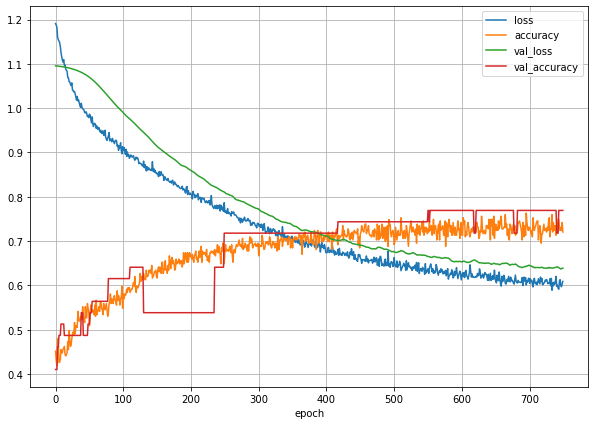

Test loss: 0.6389010548591614
Test accuracy: 0.7692307829856873


In [13]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.xlabel('epoch')
plt.grid()
plt.show()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [16]:
def process_test_buys(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[-SHIFT:]

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-2]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-2], i[-1]])  # append those bad boys!
        
        Sequential_data = Sequential_data + sequential_data
        
    X = []; y = []; z = []
    for seq, target, actual in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)
        z.append(actual)

    return np.array(X).astype("float64"), np.array(y).astype("uint8"), np.array(z).astype("float64")

In [17]:
last_trading_days = 100
test_x, test_y, test_z = process_test_buys(tickers_test, SEQ_LEN, last_trading_days)

In [18]:
output = model.predict(test_x)

In [19]:
results = []; total = 0
for i, j in zip(output, test_z):
    if np.argmax(i) == 2:
        total += 1
#         results.append([i,j])
        results.append(j)

In [20]:
print('Trading period. The last %d trading days.' % (last_trading_days))
print('Average daily return: %f percent, over %d trades.' % (np.average(results), len(results)))
start = 5000
finish = start
for i in results:
    finish = finish + (i/100) * finish
    
print('You started with $%d and finished with $%d after %d trades.' % (start, finish, len(results)))

Trading period. The last 100 trading days.
Average daily return: 3.472453 percent, over 22 trades.
You started with $5000 and finished with $10534 after 22 trades.


In [ ]:
print(results)

In [ ]:
results = []; total = 0
for i, j in zip(output, test_z):
    if i[2] > 0.6:
        total += 1
#         results.append([i,j])
        results.append(j)

In [ ]:
print('Trading period. The last %d trading days.' % (last_trading_days))
print('Average daily return: %f percent, over %d trades.' % (np.average(results), len(results)))
start = 5000
finish = start
for i in results:
    finish = finish + (i/100) * finish
    
print('You started with $%d and finished with $%d after %d trades.' % (start, finish, len(results)))

In [ ]:
print(results)

model.summary()

In [ ]:
# model.get_weights()

In [ ]:

if os.path.isfile('FAS_model.h5') is False:
    model.save('FAS_model.h5')


In [ ]:
model1 = load_model('FAS_model.h5')

In [ ]:
model1.summary()